In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

os.makedirs('plots', exist_ok=True)

df = pd.read_csv('CO2_Distillation.csv')
df.head()


,timestamp,plant_id,fuel_type,ambient_temp_C,steam_pressure_bar,flue_gas_flow_kg_hr,production_rate_unit,energy_consumption_MW,fuel_consumption_tph,scrubber_present,scrubber_efficiency,co2_net_kg_hr
0,2025-01-01 00:00:00,PlantC,Gas,19.052941,49.373604,4283.716501,76.851684,15.708920,10.927446,0,0.941419,1364.329996
1,2025-01-01 01:00:00,PlantA,Coal,33.213365,52.431235,5850.282954,60.383271,17.268680,7.664998,0,0.620086,1491.254262
2,2025-01-01 02:00:00,PlantC,Coal,20.496896,47.057575,6870.262196,99.233523,22.814553,9.719368,1,0.648636,1877.208811
3,2025-01-01 03:00:00,PlantC,Oil,28.191960,63.565834,4311.394559,116.375319,19.462776,14.035613,1,0.758011,1533.881772
4,2025-01-01 04:00:00,PlantA,Coal,23.356908,47.996474,5427.366290,122.135490,19.615673,10.222447,1,0.734708,1592.647898


In [28]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              2000 non-null   object 
 1   plant_id               2000 non-null   object 
 2   fuel_type              2000 non-null   object 
 3   ambient_temp_C         2000 non-null   float64
 4   steam_pressure_bar     2000 non-null   float64
 5   flue_gas_flow_kg_hr    2000 non-null   float64
 6   production_rate_unit   2000 non-null   float64
 7   energy_consumption_MW  2000 non-null   float64
 8   fuel_consumption_tph   2000 non-null   float64
 9   scrubber_present       2000 non-null   int64  
 10  scrubber_efficiency    2000 non-null   float64
 11  co2_net_kg_hr          2000 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 187.6+ KB


,ambient_temp_C,steam_pressure_bar,flue_gas_flow_kg_hr,production_rate_unit,energy_consumption_MW,fuel_consumption_tph,scrubber_present,scrubber_efficiency,co2_net_kg_hr
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,24.972534,49.617393,4989.079664,100.127272,19.910972,10.054904,0.483000,0.776815,1531.771902
std,5.031447,10.005502,829.424875,19.661178,4.953291,2.006416,0.499836,0.101048,186.153944
min,10.044320,18.232962,2049.307767,21.551995,3.122104,3.834876,0.000000,0.600214,943.431088
25%,21.460127,43.161514,4418.600030,87.133317,16.676082,8.683826,0.000000,0.693147,1401.302080
50%,25.000923,49.800138,4968.364568,100.413438,19.855567,10.048426,0.000000,0.774943,1525.041968
75%,28.330107,56.400388,5565.830366,113.147096,23.166242,11.400631,1.000000,0.863219,1661.803869
max,44.631189,81.129102,7823.244150,167.547658,36.888841,16.857821,1.000000,0.949955,2208.909963


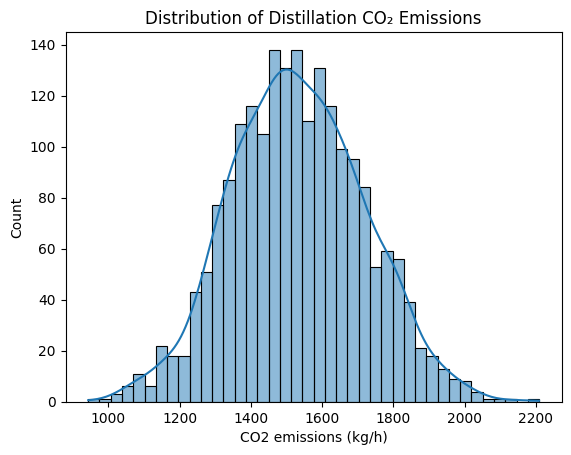

In [29]:
sns.histplot(df["co2_net_kg_hr"], bins=40, kde=True)
plt.xlabel("CO2 emissions (kg/h)")
plt.title("Distribution of Distillation CO₂ Emissions")
plt.savefig('plots/histogram_co2.png')
plt.show()
plt.close()



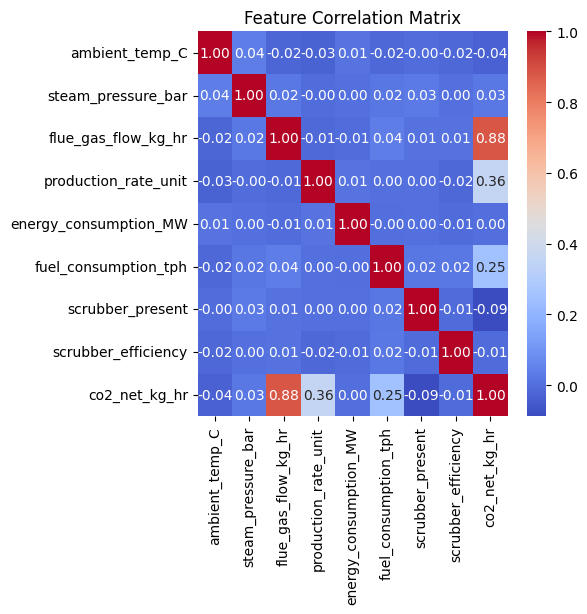

In [30]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.savefig('plots/correlation_matrix.png')
plt.show()
plt.close()


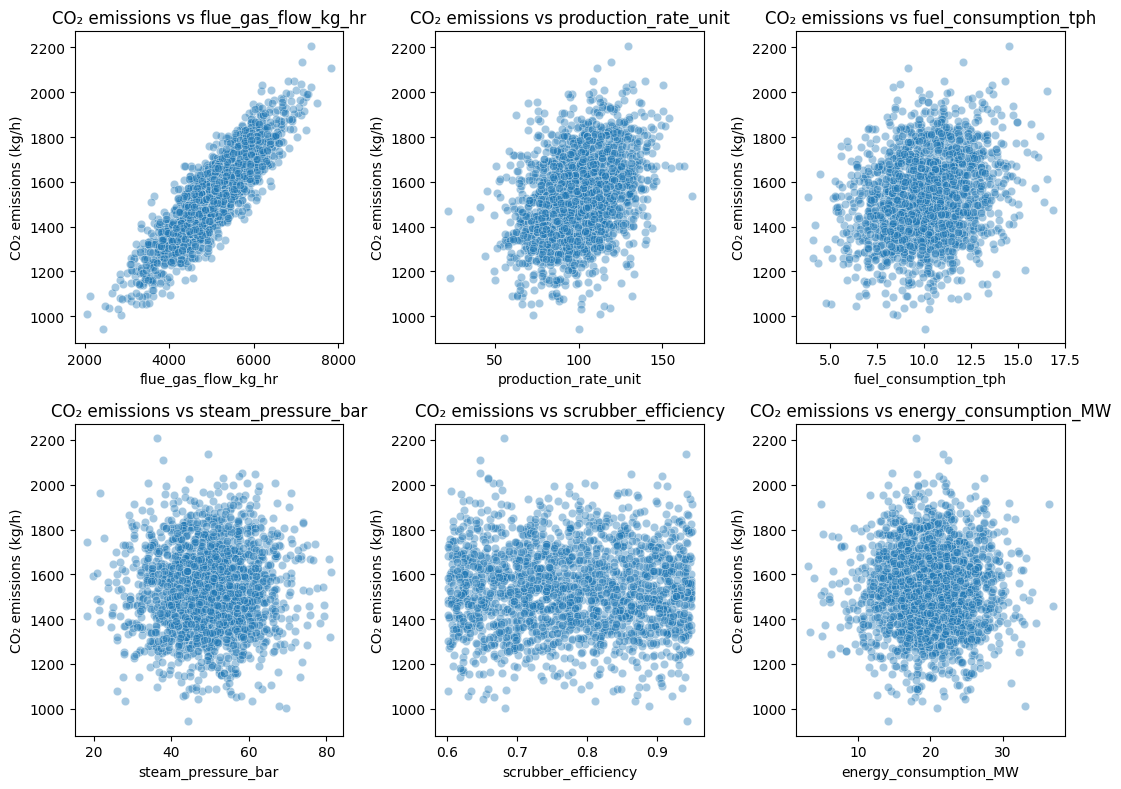

In [31]:

features_row1 = ["flue_gas_flow_kg_hr", "production_rate_unit", "fuel_consumption_tph"]
features_row2 = ["steam_pressure_bar", "scrubber_efficiency", "energy_consumption_MW"]

fig, axes = plt.subplots(2, 3, figsize=(11, 8)) 

for i, var in enumerate(features_row1):
    sns.scatterplot(x=var, y="co2_net_kg_hr", data=df, alpha=0.4, ax=axes[0, i])
    axes[0, i].set_title(f"CO₂ emissions vs {var}")
    axes[0, i].set_xlabel(var)
    axes[0, i].set_ylabel("CO₂ emissions (kg/h)")
                          
for i, var in enumerate(features_row2):
    sns.scatterplot(x=var, y="co2_net_kg_hr", data=df, alpha=0.4, ax=axes[1, i])
    axes[1, i].set_title(f"CO₂ emissions vs {var}")
    axes[1, i].set_xlabel(var)
    axes[1, i].set_ylabel("CO₂ emissions (kg/h)")

    plt.tight_layout()
plt.savefig("plots/scatter_features_2rows.png", dpi=300, bbox_inches="tight")
plt.show()


   

In [32]:
X = pd.get_dummies(df[['plant_id','fuel_type','ambient_temp_C','steam_pressure_bar','flue_gas_flow_kg_hr',
                       'production_rate_unit','energy_consumption_MW','fuel_consumption_tph',
                       'scrubber_present','scrubber_efficiency']], drop_first=True)
y = df["co2_net_kg_hr"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,3],
    'max_features': ['auto', 'sqrt']
}
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(rfr, params, n_iter=5, cv=3, scoring="neg_root_mean_squared_error", random_state=42)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("Best parameters:", rs.best_params_)
print("Best CV RMSE:", -rs.best_score_)

y_pred = best_rf.predict(X_test)
print(f"\n[Regression Model] R2: {r2_score(y_test, y_pred):.2f}, RMSE: {mean_squared_error(y_test, y_pred)**0.5:.2f}")


Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best CV RMSE: 63.49606111072453

[Regression Model] R2: 0.89, RMSE: 64.73


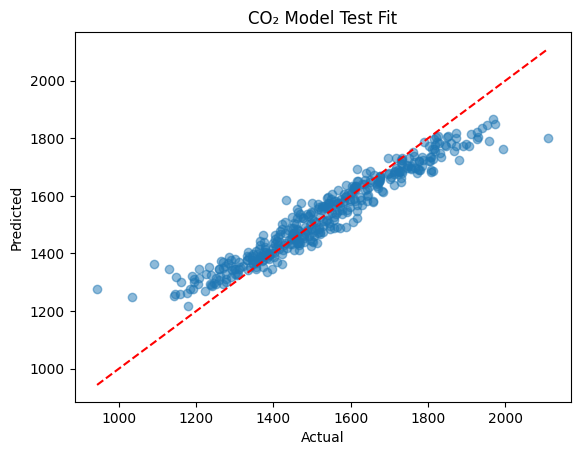

In [33]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("CO₂ Model Test Fit")
plt.savefig("plots/pred_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

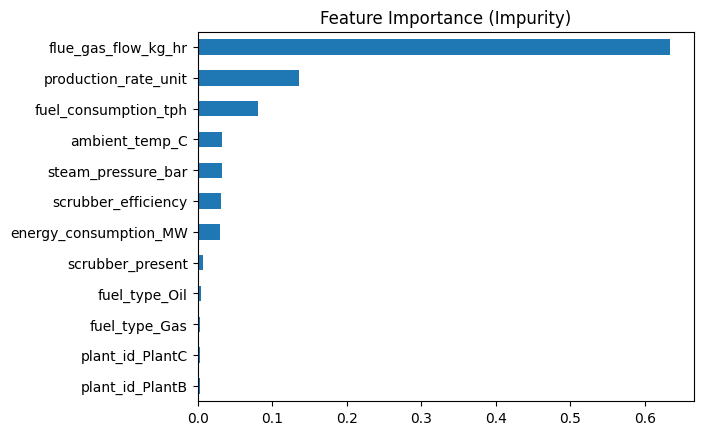

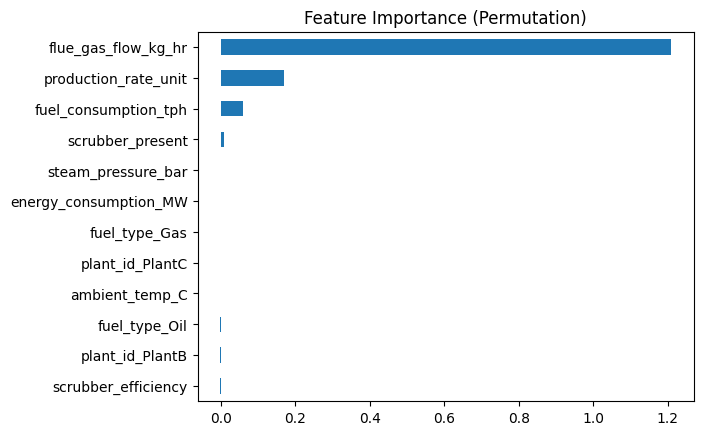

In [34]:
imp = pd.Series(best_rf.feature_importances_, index=X.columns)
imp.sort_values().plot(kind="barh")
plt.title("Feature Importance (Impurity)")
plt.savefig("plots/feature_importance_impurity.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, n_jobs=1, random_state=5)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values()
perm_imp.plot(kind="barh")
plt.title("Feature Importance (Permutation)")
plt.savefig("plots/feature_importance_perm.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


RF Classification accuracy: 0.853
Confusion matrix:
 [[121  12   0]
 [ 17 102  14]
 [  0  16 118]]


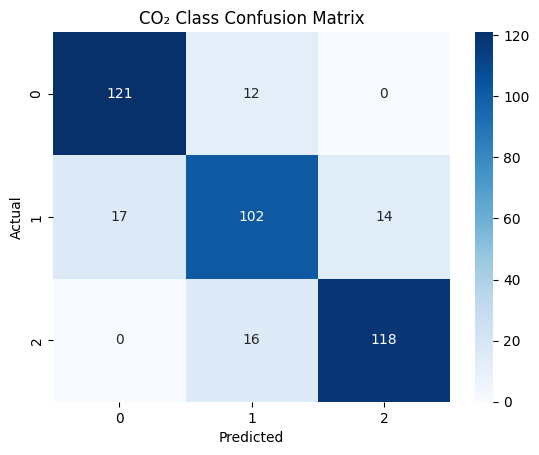

In [35]:
bins = np.percentile(df["co2_net_kg_hr"], [33.3, 66.6])
y_class = np.where(df["co2_net_kg_hr"] <= bins[0], 0,
          np.where(df["co2_net_kg_hr"] <= bins[1], 1, 2))

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y_class, test_size=0.2, random_state=5, stratify=y_class)
rfc = RandomForestClassifier(n_estimators=200, random_state=5)
rfc.fit(Xc_train, yc_train)
yc_pred = rfc.predict(Xc_test)
print(f"\nRF Classification accuracy: {accuracy_score(yc_test, yc_pred):.3f}")
print("Confusion matrix:\n", confusion_matrix(yc_test, yc_pred))
sns.heatmap(confusion_matrix(yc_test, yc_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("CO₂ Class Confusion Matrix"); 
plt.savefig("plots/conf_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()